In [32]:
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
import random

In [20]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']
Slusarski


In [22]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [66]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model,self).__init__()
        
        self.hidden_size = hidden_size

        self.i2o1 = nn.Linear(input_size + hidden_size, input_size + hidden_size)
        self.i2o2 = nn.Linear(input_size + hidden_size, output_size)
        
        self.i2h1 = nn.Linear(input_size + hidden_size, input_size + hidden_size)
        self.i2h2 = nn.Linear(input_size + hidden_size, hidden_size)

    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)

        output = F.relu(self.i2o1(combined))
        output = self.i2o2(output)

        hidden = F.relu(self.i2h1(combined))
        hidden = self.i2h2(hidden)


        output = F.softmax(output, dim=1)

        return (output, hidden)
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)



In [67]:
n_hidden = 128
rnn = Model(n_letters, n_hidden, n_categories)

In [29]:
input = torch.zeros(1,n_letters)
hidden = rnn.initHidden()
output, hidden = rnn(input, hidden)

In [30]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Polish', 17)


In [33]:

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Portuguese / line = Pinho
category = Polish / line = Filipek
category = French / line = Desrochers
category = Russian / line = Handjyan
category = Czech / line = Czabal
category = Czech / line = Kubin
category = German / line = Feldt
category = Irish / line = Brannon
category = Korean / line = Choi
category = Czech / line = Skala


In [34]:
criterion = nn.NLLLoss()

In [72]:
learning_rate = 0.001

def train(train_tensor, category_tensor):
    rnn.zero_grad()
    hidden = rnn.initHidden()

    for i in range(train_tensor.size()[0]):
        output, hidden = rnn(train_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    
    return output, loss.item()

In [73]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 8s) -0.0572 Yau / Irish ✗ (Chinese)
10000 10% (0m 17s) -0.0001 Saliba / Japanese ✗ (Arabic)
15000 15% (0m 26s) -0.9712 Jigalov / Russian ✓
20000 20% (0m 34s) -0.0050 Shui / Italian ✗ (Chinese)
25000 25% (0m 42s) -0.9989 Leontarakis / Greek ✓
30000 30% (0m 51s) -0.0458 Noro / Italian ✗ (Japanese)
35000 35% (1m 0s) -0.9841 Yamilov / Russian ✓
40000 40% (1m 8s) -0.0195 Sinagra / Japanese ✗ (Italian)
45000 45% (1m 15s) -0.0013 Tolbert / German ✗ (French)
50000 50% (1m 23s) -0.9988 Stamatelos / Greek ✓
55000 55% (1m 31s) -0.6949 Tracey / Irish ✓
60000 60% (1m 40s) -0.0001 Souza / Japanese ✗ (Portuguese)
65000 65% (1m 48s) -0.0000 Kaczka / Japanese ✗ (Polish)
70000 70% (1m 56s) -0.0014 Upjohn / Irish ✗ (English)
75000 75% (2m 4s) -0.0007 Eyres / Greek ✗ (English)
80000 80% (2m 13s) -0.0002 Azarola / Japanese ✗ (Spanish)
85000 85% (2m 21s) -0.0000 Marino / Italian ✗ (Spanish)
90000 90% (2m 29s) -0.0026 Lyon / Irish ✗ (Dutch)
95000 95% (2m 36s) -0.0001 Stewart / German ✗ (Scottish)

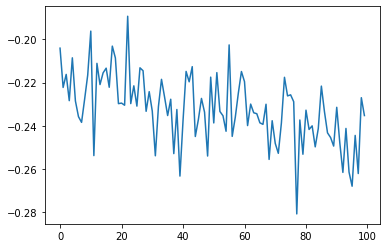

In [74]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/var/folders/3q/5f3xl4nn0hgfckgdrzj9gh5h0000gn/T/ipykernel_15811/3585656379.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/3q/5f3xl4nn0hgfckgdrzj9gh5h0000gn/T/ipykernel_15811/3585656379.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


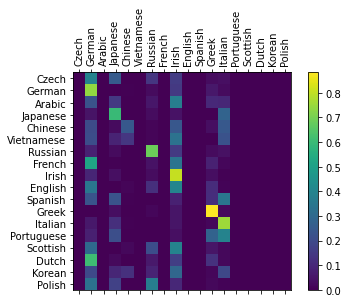

In [75]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [65]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(0.55) Russian
(0.14) Dutch
(0.10) Italian

> Jackson
(0.99) Scottish
(0.00) Russian
(0.00) Dutch

> Satoshi
(0.86) Arabic
(0.09) Italian
(0.02) Vietnamese
